In [1]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

In [7]:
chart_data = pd.DataFrame.from_csv('CHART_EVENTS_FIRST24_PROCESSED.csv')
lab_data = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24_PROCESSED.csv')
chart_data.head()

,icustay_id,subject_id,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,BP_Dia_std,BP_Mean_max,BP_Mean_mean,...,pH2_med,pH2_min,pH2_skew,pH2_std,pH_max,pH_mean,pH_med,pH_min,pH_skew,pH_std
0,200001,55973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,27513,81.0,42.708333,60.5,0.0,-0.623249,31.452489,179.0,87.411765,...,7.38,7.36,1.220037,0.038987,7.46,7.398,7.38,7.36,1.220037,0.038987
2,200006,10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,20707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,29904,84.0,62.645161,57.0,49.0,0.868910,10.931753,101.0,74.741935,...,7.39,7.29,0.360059,0.071063,7.50,7.380,7.39,7.29,0.360059,0.071063


In [57]:
donkey = [x for x in chart_data.columns if 'time' in x]
for donk in donkey:
    chart_data[donk] = pd.to_datetime(chart_data[donk])

for index, row in chart_data.iterrows():
    staylen = relativedelta(row['outtime'], row['intime']).hours
    chart_data.set_value(index, 'stay_duration', staylen)


icustay_id                       int64
subject_id                       int64
BP_Dia_max                     float64
BP_Dia_mean                    float64
BP_Dia_med                     float64
BP_Dia_min                     float64
BP_Dia_skew                    float64
BP_Dia_std                     float64
BP_Mean_max                    float64
BP_Mean_mean                   float64
BP_Mean_med                    float64
BP_Mean_min                    float64
BP_Mean_skew                   float64
BP_Mean_std                    float64
BP_Sys_max                     float64
BP_Sys_mean                    float64
BP_Sys_med                     float64
BP_Sys_min                     float64
BP_Sys_skew                    float64
BP_Sys_std                     float64
Cap_refill                      object
GCS_Eye                         object
GCS_Motor                       object
GCS_Verbal                      object
GCS_total                      float64
HR_max                   

## Isolate continuous (float64) and categorical variables for feature selection process. 
Feature selection tools require features to be of the same type. Data will be separated, feature correlations will be calculated. 
### height, weight, gcs_total are not being included in these groupings and should be considered separately

In [62]:
monkey = list(chart_data.columns[chart_data.dtypes == 'float64'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
monkey.pop(monkey.index('Height'))
monkey.pop(monkey.index('Weight'))
cont_data = chart_data[monkey]

monkey = list(chart_data.columns[chart_data.dtypes == 'object'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
cat_data = chart_data[monkey]

In [65]:
cont_data.columns

Index([u'icustay_id', u'hospital_expire_flag', u'BP_Dia_max', u'BP_Dia_mean',
       u'BP_Dia_med', u'BP_Dia_min', u'BP_Dia_skew', u'BP_Dia_std',
       u'BP_Mean_max', u'BP_Mean_mean', u'BP_Mean_med', u'BP_Mean_min',
       u'BP_Mean_skew', u'BP_Mean_std', u'BP_Sys_max', u'BP_Sys_mean',
       u'BP_Sys_med', u'BP_Sys_min', u'BP_Sys_skew', u'BP_Sys_std',
       u'GCS_total', u'HR_max', u'HR_mean', u'HR_med', u'HR_min', u'HR_skew',
       u'HR_std', u'O2_Fraction_max', u'O2_Fraction_mean', u'O2_Fraction_med',
       u'O2_Fraction_min', u'O2_Fraction_skew', u'O2_Fraction_std', u'RR_max',
       u'RR_mean', u'RR_med', u'RR_min', u'RR_skew', u'RR_std',
       u'TempC_Calc_max', u'TempC_Calc_mean', u'TempC_Calc_med',
       u'TempC_Calc_min', u'TempC_Calc_skew', u'TempC_Calc_std', u'TempC_max',
       u'TempC_mean', u'TempC_med', u'TempC_min', u'TempC_skew', u'TempC_std',
       u'pH2_max', u'pH2_mean', u'pH2_med', u'pH2_min', u'pH2_skew',
       u'pH2_std', u'pH_max', u'pH_mean', u'pH_med'

## This filtering on feature selection could be done far earlier in the process. Could do it in smaller blocks where the variables are aligned with the subject ID
Variables are not present for all subject_id's or ICU stays. In order to select features, we need to drop_na. So we need to find blocks of features that are present for the same ICU stays etc. In retrospect this could be done earlier in the process before all the data is merged. 
### GCS_total, stay_duration are not included in these blocks and need to be considered separately 

In [ ]:
cols = [x for x in cont_data.columns if 'BP_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_BP = cont_data[cols].dropna()
print "BP  = {}".format(cont_data_BP.shape[0])

cols = [x for x in cont_data.columns if 'HR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_HR = cont_data[cols].dropna()
print "HR  = {}".format(cont_data_HR.shape[0])

cols = [x for x in cont_data.columns if 'O2_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2 = cont_data[cols].dropna()
print "O2  = {}".format(cont_data_O2.shape[0])

cols = [x for x in cont_data.columns if 'RR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_RR = cont_data[cols].dropna()
print "RR  = {}".format(cont_data_RR.shape[0])


cols = [x for x in cont_data.columns if 'TempC_Calc' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TCalc = cont_data[cols].dropna()
print "TCalc  = {}".format(cont_data_TCalc.shape[0])

cols = [x for x in cont_data.columns if (('TempC_' in x) & ('TempC_C' not in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TC = cont_data[cols].dropna()
print "TC  = {}".format(cont_data_TC.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('pH2_' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_pH = cont_data[cols].dropna()
print "pH  = {}".format(cont_data_pH.shape[0])

In [71]:
cont_dict = {'BP': cont_data_BP, 
             'HR': cont_data_HR, 
             'O2': cont_data_O2, 
             'RR': cont_data_RR, 
             'TCalc': cont_data_TCalc, 
             'TC': cont_data_TC,
             'pH': cont_data_pH
            }

In [67]:
cat_data.columns

Index([u'icustay_id', u'hospital_expire_flag', u'Cap_refill', u'GCS_Eye',
       u'GCS_Motor', u'GCS_Verbal', u'gender'],
      dtype='object')

In [68]:
for col in cat_data.columns:
    print "{} has  {} NaN values".format(col, cat_data[col].isnull().sum())

icustay_id has  0 NaN values
hospital_expire_flag has  0 NaN values
Cap_refill has  54204 NaN values
GCS_Eye has  36828 NaN values
GCS_Motor has  36841 NaN values
GCS_Verbal has  36838 NaN values
gender has  0 NaN values


## Cap refill and gender are not included in this block and should be evaluated separately

In [70]:
cols = [x for x in cat_data.columns if ('GCS_' in x)]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cat_data_GCS = cat_data[cols].dropna()
print "GCS  = {}".format(cat_data_GCS.shape[0])



GCS  = 23280


In [72]:
cont_dict.keys()

['RR', 'HR', 'TCalc', 'TC', 'BP', 'pH', 'O2']

In [75]:
X_cont = cont_dict['RR'].drop(['hospital_expire_flag', 'icustay_id'], axis = 1)
y_cont = cont_dict['RR']['hospital_expire_flag']
below_zeros = list(X_cont.columns[X_cont.min() < 0])
for col in below_zeros:
    col_min = X_cont[col].min()
    X_cont[col] = X_cont[col].apply(lambda x: x-col_min)
    
display(X_cont.min())

RR_max     4.000000
RR_mean    0.642857
RR_med     0.000000
RR_min     0.000000
RR_skew    0.000000
RR_std     0.000000
dtype: float64

In [80]:





cont_dict_RR
selector = SelectKBest(k='all', score_func = chi2)
selector.fit(X_cont, y_cont)

for i in range(len(selector.pvalues_)):
    print "{}          {}             {}".format(selector.pvalues_[i], selector.scores_[i], X_cont.columns[i])
#X_new, p_vals = SelectKBest(chi2, k=10).fit_transform(X_continuous, y)
#X_new.shape
largest = pd.Series(selector.scores_).nlargest(10)
X_cont.columns[largest.index]

0.0          182851.958257             RR_max
0.0833645734046          2.99805438487             RR_mean
0.0          1525.46698422             RR_med
1.45687019826e-15          63.6891195044             RR_min
9.37222577269e-11          41.9482284181             RR_skew
0.0          39512.2622246             RR_std


Index([u'RR_max', u'RR_std', u'RR_med', u'RR_min', u'RR_skew', u'RR_mean'], dtype='object')

In [101]:


cont_dict_RR = cont_dict['RR'].drop(list(cont_dict['RR']['RR_max'].nlargest(3).index))
cont_dict_RR['RR_max'].nlargest(10)

41818    240.0
53578    240.0
24885    220.0
39293    210.0
38807    200.0
36641    170.0
48099    167.0
40460    160.0
45247    160.0
7030     152.0
Name: RR_max, dtype: float64

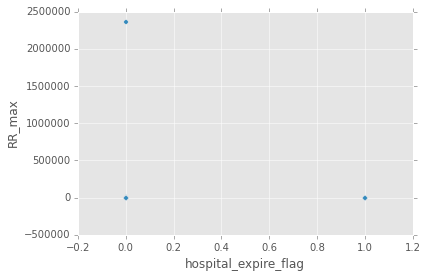

In [83]:
cont_dict['RR'].plot.scatter(x='hospital_expire_flag', y='RR_max')